# Capstone Project: Data Insights / Time series analysis

#### *by Pol Reviejo*

Let's first import the libraries we are going to use for this project

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans
from pmdarima import auto_arima


## Step 0: Import the data with the preprocess of Carles Onielfa

We import the data which includes cases with ```status = MAINTENANCE```

In [2]:
# Open data
df_data = pd.read_parquet("cleaned_maintenance_data.parquet")
# Set dtypes
types = {
    "hour": int,
    "day": int,
    "month": int,
    "year": int,
    "is_renting": bool,
    "is_returning": bool,
    "is_installed": bool,
}
df_data = df_data.astype(types)
df_data.head()

,station_id,hour,day,month,year,num_bikes_available,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,num_docks_available,status,is_renting,is_returning,is_installed
0,1,0,1,1,2020,23.333333,23.166667,0.166667,20.666667,IN_SERVICE,True,True,True
1,1,0,2,1,2020,25.583333,22.583333,3.000000,17.416667,IN_SERVICE,True,True,True
2,1,0,3,1,2020,40.416667,36.500000,3.916667,3.583333,IN_SERVICE,True,True,True
3,1,0,4,1,2020,10.769231,10.769231,0.000000,33.230769,IN_SERVICE,True,True,True
4,1,0,5,1,2020,15.750000,15.500000,0.250000,27.250000,IN_SERVICE,True,True,True


**Adjust by Pol:** In order to simplify the time series we'll study at day level so we are going to take the mean value of each day, we are going to make the hours dissappear

In [3]:
keep_columns = ['station_id', 'day', 'month', 'year',
                'num_bikes_available', 'num_bikes_available_types.mechanical',
                'num_bikes_available_types.ebike', 'num_docks_available']

df_data = df_data[keep_columns].groupby(['station_id', 'day', 'month', 'year']).mean().reset_index()

We import the Excel which includes info of the stations

In [4]:
df_stations = pd.read_csv("Informacio_Estacions_Bicing.csv")
df_stations.head()

,station_id,name,physical_configuration,lat,lon,altitude,address,post_code,capacity,is_charging_station,nearby_distance,_ride_code_support,rental_uris,cross_street
0,1,"GRAN VIA CORTS CATALANES, 760",ELECTRICBIKESTATION,41.397978,2.180107,16.0,"GRAN VIA CORTS CATALANES, 760",8013,45,True,1000.0,True,NaN,NaN
1,2,"C/ ROGER DE FLOR, 126",ELECTRICBIKESTATION,41.395488,2.177198,17.0,"C/ ROGER DE FLOR, 126",8013,29,True,1000.0,True,NaN,NaN
2,3,"C/ NÀPOLS, 82",ELECTRICBIKESTATION,41.394156,2.181331,11.0,"C/ NÀPOLS, 82",8013,27,True,1000.0,True,NaN,NaN
3,4,"C/ RIBES, 13",ELECTRICBIKESTATION,41.393317,2.181248,8.0,"C/ RIBES, 13",8013,21,True,1000.0,True,NaN,NaN
4,5,"PG. LLUIS COMPANYS, 11 (ARC TRIOMF)",ELECTRICBIKESTATION,41.391103,2.180176,7.0,"PG. LLUIS COMPANYS, 11 (ARC TRIOMF)",8018,39,True,1000.0,True,NaN,NaN


We do a left join the two information so we can have the info instant state of the station saves in ```df_data``` and also his features given by ```df_station```

In [5]:
df_data = pd.merge(df_data, df_stations[
    ["station_id","name","lat","lon","altitude", "capacity", "is_charging_station","post_code"]],
    on="station_id", how="inner")

We calculate ```ctx```, the % of avalability

In [6]:
df_data["ctx"] = df_data["num_docks_available"] / df_data["capacity"] 

We create a unique id of the state of the station which is ```datetime``` 

In [7]:
df_data["datetime"] = pd.to_datetime(df_data[["year", "month", "day"]])

In [8]:
df_data = df_data.sort_values(by=['station_id', 'datetime'])
df_data

,station_id,day,month,year,num_bikes_available,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,num_docks_available,name,lat,lon,altitude,capacity,is_charging_station,post_code,ctx,datetime
1391,1,31,12,2019,21.416667,21.375000,0.041667,22.583333,"GRAN VIA CORTS CATALANES, 760",41.397978,2.180107,16.0,45,True,8013,0.501852,2019-12-31
0,1,1,1,2020,29.333333,28.746528,0.586806,14.270833,"GRAN VIA CORTS CATALANES, 760",41.397978,2.180107,16.0,45,True,8013,0.317130,2020-01-01
46,1,2,1,2020,21.103365,20.045139,1.058226,22.739583,"GRAN VIA CORTS CATALANES, 760",41.397978,2.180107,16.0,45,True,8013,0.505324,2020-01-02
91,1,3,1,2020,23.970328,22.732299,1.238029,20.029672,"GRAN VIA CORTS CATALANES, 760",41.397978,2.180107,16.0,45,True,8013,0.445104,2020-01-03
137,1,4,1,2020,7.729968,7.427885,0.302083,36.086004,"GRAN VIA CORTS CATALANES, 760",41.397978,2.180107,16.0,45,True,8013,0.801911,2020-01-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
691207,519,27,12,2023,4.012116,0.000000,4.012116,17.987884,"C/ PEDRELL, 52",41.424655,2.166289,110.0,24,True,8032,0.749495,2023-12-27
691247,519,28,12,2023,4.669071,0.000000,4.669071,17.990652,"C/ PEDRELL, 52",41.424655,2.166289,110.0,24,True,8032,0.749610,2023-12-28
691284,519,29,12,2023,1.645833,0.000000,1.645833,21.312500,"C/ PEDRELL, 52",41.424655,2.166289,110.0,24,True,8032,0.888021,2023-12-29
691323,519,30,12,2023,6.693740,0.000000,6.693740,16.066676,"C/ PEDRELL, 52",41.424655,2.166289,110.0,24,True,8032,0.669445,2023-12-30


## Step 1: Understanding the data

We are going to see the length of the time series of each station and plot some of them for some stations

In [9]:
df_data["station_id"].nunique()

506

In [10]:
df_data["station_id"].value_counts().sort_index()

station_id
1      1396
2      1375
3      1398
4      1398
5      1394
       ... 
515    1321
516    1304
517    1265
518    1246
519    1263
Name: count, Length: 506, dtype: int64

There are 506 stations:

Most of the station time series have the same number of observations:

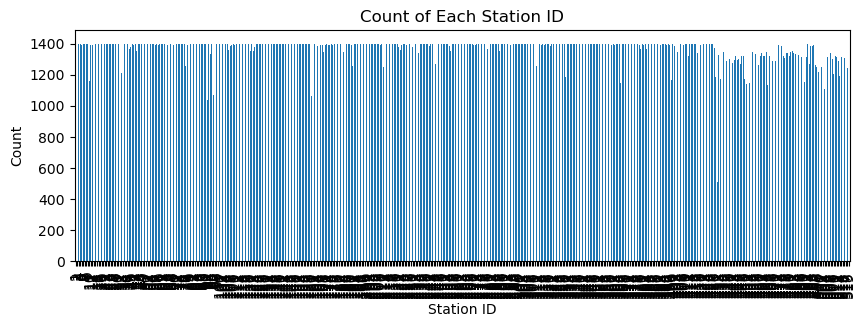

In [11]:
df_data["station_id"].value_counts().sort_index().plot(kind='bar', figsize=(10, 3))
plt.title('Count of Each Station ID')
plt.xlabel('Station ID')
plt.ylabel('Count')
plt.show()

Let's plot four station time series

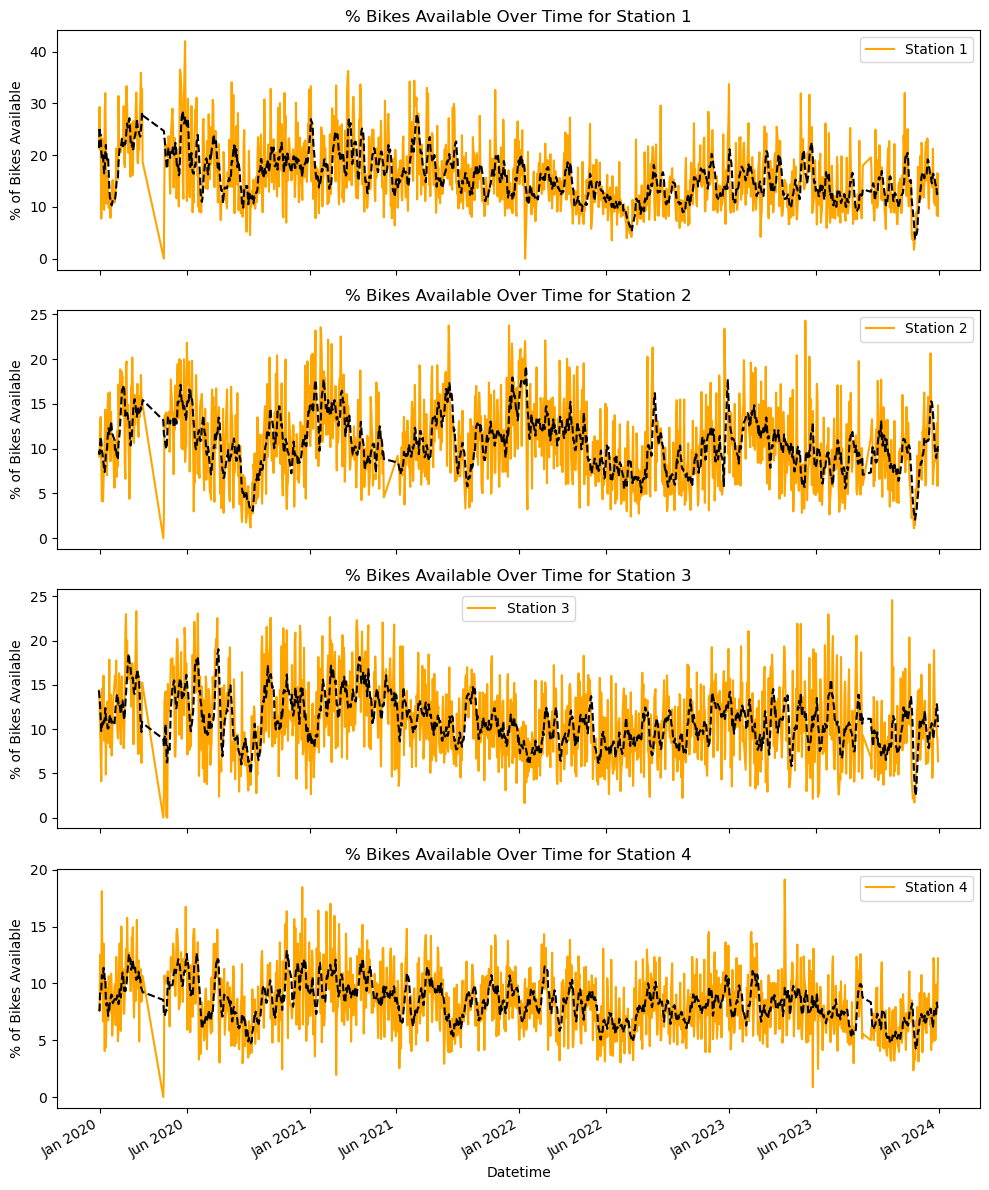

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Assuming you have a DataFrame `df_data` loaded with your data
# Example: df_data = pd.read_csv('your_data.csv')

# Filter the DataFrame for rows where station_id is in [1, 2, 44]
station_1 = df_data[df_data["station_id"].isin([1, 2, 3, 4])].copy()  # Make a copy to avoid SettingWithCopyWarning

# Ensure 'datetime' is recognized as a datetime type
station_1.loc[:, 'datetime'] = pd.to_datetime(station_1['datetime'])  # Use .loc to modify original DataFrame

# Define the number of subplots (one for each station)
num_stations = station_1['station_id'].nunique()
fig, axes = plt.subplots(num_stations, 1, figsize=(10, 3 * num_stations), sharex=True)

# Ensure axes is iterable if there's only one subplot
if num_stations == 1:
    axes = [axes]

# Plot each station_id separately in different subplots
for ax, (station_id, group_data) in zip(axes, station_1.groupby('station_id')):
    ax.plot(group_data['datetime'], group_data['num_bikes_available'], label=f'Station {station_id}',color='orange')
    ax.set_title(f'% Bikes Available Over Time for Station {station_id}')
    ax.set_xlabel('Datetime')
    ax.set_ylabel('% of Bikes Available')
    ax.legend()
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 6)))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

    # Calculate moving average with window size of 7
    moving_avg = group_data['num_bikes_available'].rolling(window=7, min_periods=1).mean()
    
    # Plot moving average
    ax.plot(group_data['datetime'], moving_avg, label=f'Moving Average (Order 7)', color='black', linestyle='--')
    
# Improve the x-axis date format for better readability
plt.gcf().autofmt_xdate()

# Show the plot
plt.tight_layout()
plt.show()


## Step 2: Does the location of station affect it's ```ctx```? Clustering stations

Let's see the lattitude, longitude and altitude of each station in a 3d scatterplot

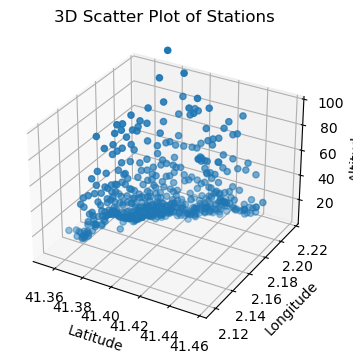

In [13]:
# Assuming you have a DataFrame `df_stations` with columns: "lat", "lon", and "altitude"

# Create a new figure and 3D axis
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D scatter plot
ax.scatter(df_stations["lat"], df_stations["lon"], df_stations["altitude"])

# Set labels and title
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.set_zlabel('Altitude')
ax.set_title('3D Scatter Plot of Stations')

# Set limits for x, y, and z axes
ax.set_xlim(df_stations["lat"].min(), df_stations["lat"].max()) # latitu
ax.set_ylim(df_stations["lon"].min(), df_stations["lon"].max())
ax.set_zlim(df_stations["altitude"].min(), 100)

# Show the plot
plt.show()

I am going to perform a clustering analysis of each station based on it's $(x,y,z)$ coordinates, so we will have different group of stations. 

Let's do a K Means clustering for the location.

In [14]:
# Extract the features for clustering
X = df_stations[["lat", "lon", "altitude"]]
# Perform k-means clustering with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)
# Add cluster labels to the DataFrame
df_stations['cluster'] = kmeans.labels_
# Print the cluster centers
print("Cluster Centers:")
print(kmeans.cluster_centers_)

C:\Users\Pol\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Pol\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Pol\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(
C:\Users\Pol\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

Cluster Centers:
[[ 41.40455422   2.15655844  50.1369863 ]
 [ 41.39410341   2.17892763  13.24067797]
 [ 41.414371     2.146521   101.21538462]]


We can see the stations in the previous 3d scatterplot with its corresponding cluster

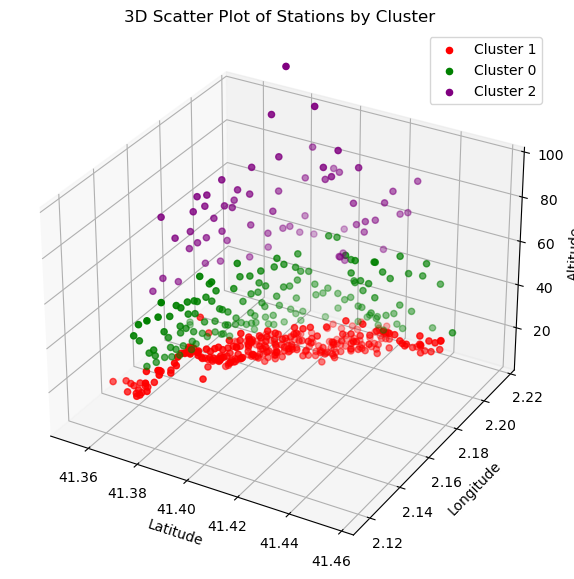

In [15]:
# Calculate the mean coordinates for each cluster
cluster_means = df_stations.groupby('cluster')[['lat', 'lon', 'altitude']].mean()
# Create a new figure and 3D axis
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
# Iterate over unique cluster labels and plot each cluster with a different color
color_l = ['red','green','purple']
i=0
for cluster_label in df_stations['cluster'].unique():
    cluster_data = df_stations[df_stations['cluster'] == cluster_label]
    ax.scatter(cluster_data["lat"], cluster_data["lon"], cluster_data["altitude"],
               label=f'Cluster {cluster_label}',
               color=color_l[i])
    i=i+1
# Set labels and title
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.set_zlabel('Altitude')
ax.set_title('3D Scatter Plot of Stations by Cluster')
# Set limits for x, y, and z axes
ax.set_xlim(df_stations["lat"].min(), df_stations["lat"].max()) # latitu
ax.set_ylim(df_stations["lon"].min(), df_stations["lon"].max())
ax.set_zlim(df_stations["altitude"].min(), 100)
# Add a legend
ax.legend()
# Show the plot
plt.show()

We calculate the daily time series of the % of availabilty grouping by the location cluster of station

In [16]:
# Merge df_data and df_stations 
df_data2 = pd.merge(df_data, df_stations[["station_id","cluster"]], on="station_id", how="inner")

keep_columns = ['cluster', 'day', 'month', 'year', 'ctx']
cluster_data = df_data2[keep_columns].groupby(['cluster', 'day', 'month', 'year']).mean().reset_index()
cluster_data["datetime"] = pd.to_datetime(cluster_data[["year", "month", "day"]])
cluster_data = cluster_data.sort_values(by=['cluster', 'datetime'])
cluster_data

,cluster,day,month,year,ctx,datetime
828,0,18,12,2019,1.000000,2019-12-18
1394,0,31,12,2019,0.801483,2019-12-31
0,0,1,1,2020,0.738461,2020-01-01
46,0,2,1,2020,0.691866,2020-01-02
91,0,3,1,2020,0.695295,2020-01-03
...,...,...,...,...,...,...
4066,2,27,12,2023,0.674501,2023-12-27
4110,2,28,12,2023,0.685948,2023-12-28
4151,2,29,12,2023,0.681145,2023-12-29
4193,2,30,12,2023,0.668402,2023-12-30


We can see how effectively the location of the station it's relevant. For the different stations location in the three diferent groups of the city we appreciate a different behaviour. We can see how the stations which are in the cluster 2, the ones with a biggest altitude of the city tend to a have a higher ctx value. The ones with a lower altitude, which are the stationes who belong to the cluster 1 have also a lower ctx. Thus, this graphic could suggest that the hugher is the altitude of the stations the higher will be the ctx.

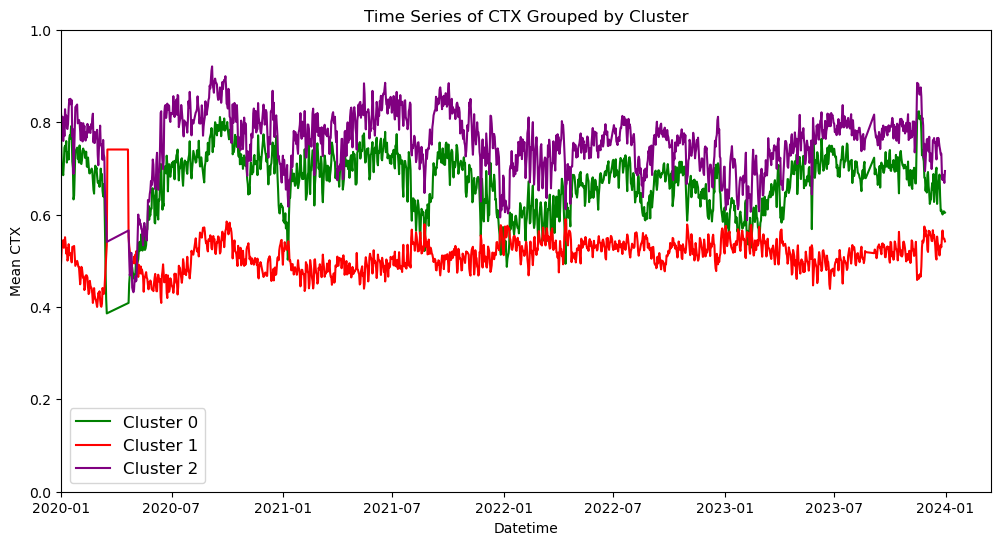

In [17]:
color_l = ['green','red','purple']
i=0

plt.figure(figsize=(12, 6))
for cluster_label in cluster_data['cluster'].unique():
    cluster_subset = cluster_data[cluster_data['cluster'] == cluster_label]
    plt.plot(cluster_subset['datetime'], cluster_subset['ctx'],
             label=f'Cluster {cluster_label}',
             color=color_l[i])
    i=i+1
plt.xlabel('Datetime')
plt.ylabel('Mean CTX')
plt.title('Time Series of CTX Grouped by Cluster')
plt.legend(fontsize='large')
plt.xlim(pd.Timestamp('2020-01-01'), None)
plt.ylim(0, 1)

plt.show()

Let's verify the hypothesis of ```altitude``` and ```ctx```:

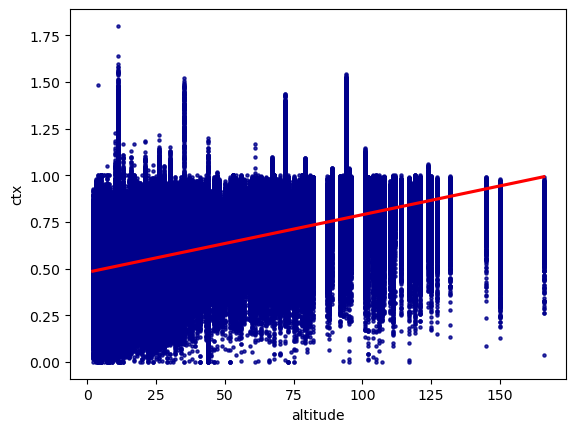

In [18]:
# Plot with customized points and regression line
sns.regplot(
    x=df_data["altitude"],
    y=df_data["ctx"],
    scatter_kws={'s': 5, 'color': 'darkblue'},   # Points: size 10, darkblue color
    line_kws={'color': 'red'}                     # Regression line: red color
)

# Show the plot
plt.show()

## Step 3: Days of the week

Let's see if the day of the week is relevant in order to explain the ```ctx``` level. First of all, we create a dataset with the days of the week from January 1 of 2020 to December 31 of 2023.

In [19]:
# Create a date range from 2020-01-01 to 2023-12-31
date_range = pd.date_range(start='2019-01-01', end='2023-12-31')

# Create a DataFrame from the date range
week_days = pd.DataFrame({
    'year': date_range.year,
    'month': date_range.month,
    'day': date_range.day,
    'day_of_the_week': date_range.day_name()
})

week_days["datetime"] = pd.to_datetime(week_days[["year", "month", "day"]])
week_days

,year,month,day,day_of_the_week,datetime
0,2019,1,1,Tuesday,2019-01-01
1,2019,1,2,Wednesday,2019-01-02
2,2019,1,3,Thursday,2019-01-03
3,2019,1,4,Friday,2019-01-04
4,2019,1,5,Saturday,2019-01-05
...,...,...,...,...,...
1821,2023,12,27,Wednesday,2023-12-27
1822,2023,12,28,Thursday,2023-12-28
1823,2023,12,29,Friday,2023-12-29
1824,2023,12,30,Saturday,2023-12-30


Let's add this information to ```df_data```

In [20]:
df_data = pd.merge(df_data, week_days[["datetime","day_of_the_week"]], on="datetime", how="inner")
df_data

,station_id,day,month,year,num_bikes_available,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,num_docks_available,name,lat,lon,altitude,capacity,is_charging_station,post_code,ctx,datetime,day_of_the_week
0,1,31,12,2019,21.416667,21.375000,0.041667,22.583333,"GRAN VIA CORTS CATALANES, 760",41.397978,2.180107,16.0,45,True,8013,0.501852,2019-12-31,Tuesday
1,2,31,12,2019,9.708333,8.708333,1.000000,16.291667,"C/ ROGER DE FLOR, 126",41.395488,2.177198,17.0,29,True,8013,0.561782,2019-12-31,Tuesday
2,3,31,12,2019,14.375000,14.375000,0.000000,9.625000,"C/ NÀPOLS, 82",41.394156,2.181331,11.0,27,True,8013,0.356481,2019-12-31,Tuesday
3,4,31,12,2019,7.666667,7.666667,0.000000,13.333333,"C/ RIBES, 13",41.393317,2.181248,8.0,21,True,8013,0.634921,2019-12-31,Tuesday
4,5,31,12,2019,13.666667,11.333333,2.333333,24.291667,"PG. LLUIS COMPANYS, 11 (ARC TRIOMF)",41.391103,2.180176,7.0,39,True,8018,0.622863,2019-12-31,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
691343,389,16,4,2020,0.000000,6.000000,0.000000,20.000000,RECINTE PARC DE LA CIUTADELLA,41.387390,2.187545,4.0,27,True,8003,0.740741,2020-04-16,Thursday
691344,389,17,4,2020,0.000000,6.000000,0.000000,20.000000,RECINTE PARC DE LA CIUTADELLA,41.387390,2.187545,4.0,27,True,8003,0.740741,2020-04-17,Friday
691345,389,18,4,2020,0.000000,6.000000,0.000000,20.000000,RECINTE PARC DE LA CIUTADELLA,41.387390,2.187545,4.0,27,True,8003,0.740741,2020-04-18,Saturday
691346,389,19,4,2020,0.000000,6.000000,0.000000,20.000000,RECINTE PARC DE LA CIUTADELLA,41.387390,2.187545,4.0,27,True,8003,0.740741,2020-04-19,Sunday


Now we have to take the mean value grouping by the day of the week

In [21]:
keep_columns = ['day_of_the_week', 'day', 'month', 'year', 'ctx']

cluster_data = df_data[keep_columns].groupby(['day_of_the_week', 'day', 'month', 'year']).mean().reset_index()
cluster_data["datetime"] = pd.to_datetime(cluster_data[["year", "month", "day"]])
cluster_data = cluster_data.sort_values(by=['day_of_the_week', 'datetime'])
cluster_data

,day_of_the_week,day,month,year,ctx,datetime
122,Friday,18,10,2019,1.000000,2019-10-18
100,Friday,15,11,2019,1.483583,2019-11-15
12,Friday,3,1,2020,0.604643,2020-01-03
59,Friday,10,1,2020,0.597608,2020-01-10
108,Friday,17,1,2020,0.614081,2020-01-17
...,...,...,...,...,...,...
1415,Wednesday,29,11,2023,0.610310,2023-11-29
1259,Wednesday,6,12,2023,0.600056,2023-12-06
1307,Wednesday,13,12,2023,0.603507,2023-12-13
1356,Wednesday,20,12,2023,0.600331,2023-12-20


Next we plot the time series grouping by the day of the week. We dpn't appreciate differences at all for the 7 time series.

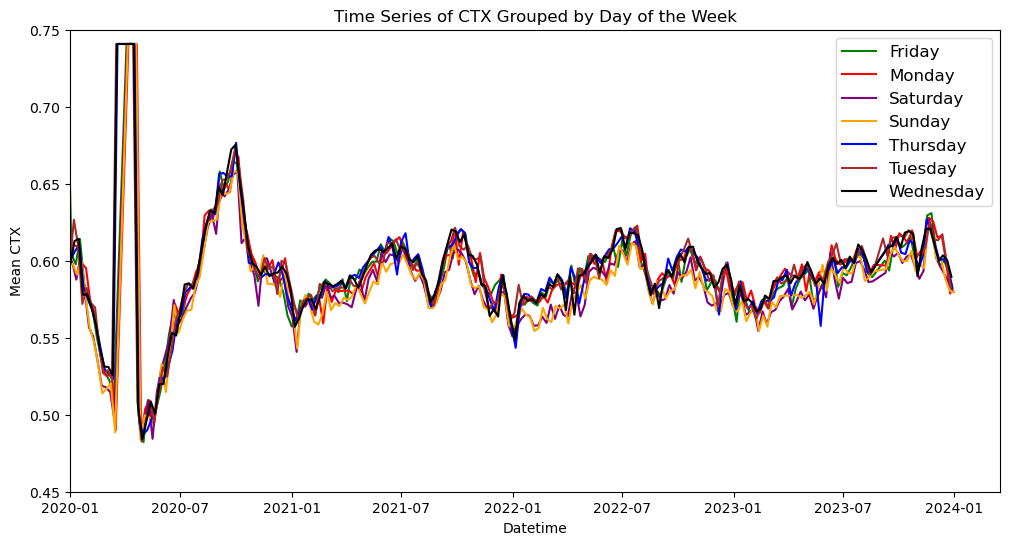

In [22]:
color_l = ['green','red','purple','orange','blue','brown','black']
i=0

plt.figure(figsize=(12, 6))
for cluster_label in cluster_data['day_of_the_week'].unique():
    cluster_subset = cluster_data[cluster_data['day_of_the_week'] == cluster_label]
    plt.plot(cluster_subset['datetime'], cluster_subset['ctx'],
             label=f'{cluster_label}',
             color=color_l[i])
    i=i+1
plt.xlabel('Datetime')
plt.ylabel('Mean CTX')
plt.title('Time Series of CTX Grouped by Day of the Week')
plt.legend(fontsize='large')
plt.xlim(pd.Timestamp('2020-01-01'), None)
plt.ylim(0.45, 0.75)

plt.show()

## Step 4: Forecasting daily ctx with ARIMA models

In [23]:
def predict_station(estacio_triada):
    # Assuming df_data is your dataframe
    df_station_1 = df_data[df_data['station_id'] == estacio_triada]
    df_station_1 = df_station_1.sort_values(["datetime"])
    # Ensure 'datetime' column is in datetime format and set it as the index
    #df_station_1['datetime'] = pd.to_datetime(df_station_1['datetime'])
    df_station_1.set_index('datetime', inplace=True)
    # Keep only the 'ctx' column for forecasting
    df_station_1 = df_station_1[['ctx']]
    
    ## FIRST PLOT
    # Plot the time series
    plt.figure(figsize=(10, 5))
    plt.plot(df_station_1.index, df_station_1['ctx'], label='ctx')
    plt.title('Time Series of ctx for Station 1')
    plt.xlabel('Date')
    plt.ylabel('ctx')
    plt.legend()
    plt.show()

    # Split the data into training and testing sets
    train_size = int(len(df_station_1) * 0.8)
    train, test = df_station_1[:train_size], df_station_1[train_size:]
    
    # Fit ARIMA model on the training data
    arima_model = auto_arima(train, seasonal=True, stepwise=True, suppress_warnings=True)
    # Forecast
    n_periods = len(test)
    forecast, conf_int = arima_model.predict(n_periods=n_periods, return_conf_int=True,suppress_warnings=True)
    # Create forecast table
    test_index = pd.DataFrame( test.index ) # time index
    test_index["dummy"] = range(n_periods)
    forecast_index = pd.DataFrame( forecast ) # forecast 
    forecast_index["dummy"] = range(n_periods)
    forecast_index["forecast"]=forecast_index[0]
    forecast_df = pd.merge(test_index, forecast_index[["forecast","dummy"]],
                            on="dummy", how="inner")[["datetime","forecast"]]
    forecast_df.set_index('datetime', inplace=True)
    
    ## SECOND PLOT
    # Plot the results
    plt.figure(figsize=(10, 5))
    plt.plot(train.index, train['ctx'], label='Train',color='red')
    plt.plot(test.index, test['ctx'], label='Test', color='orange')
    plt.plot(forecast_df.index, forecast_df['forecast'], label='Forecast', color='green')
    #plt.fill_between(conf_int_df.index, conf_int_df['lower_conf'], conf_int_df['upper_conf'], color='k', alpha=0.1)
    plt.title('ARIMA Forecast for ctx of Station'+str(estacio_triada))
    plt.xlabel('Date')
    plt.ylabel('ctx')
    plt.legend()
    plt.show()

Example: Predict ```station_id = 1```

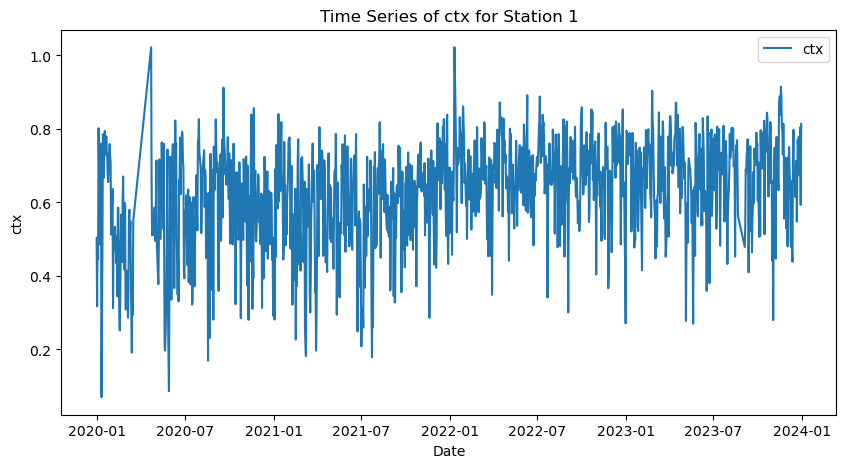

C:\Users\Pol\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Pol\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


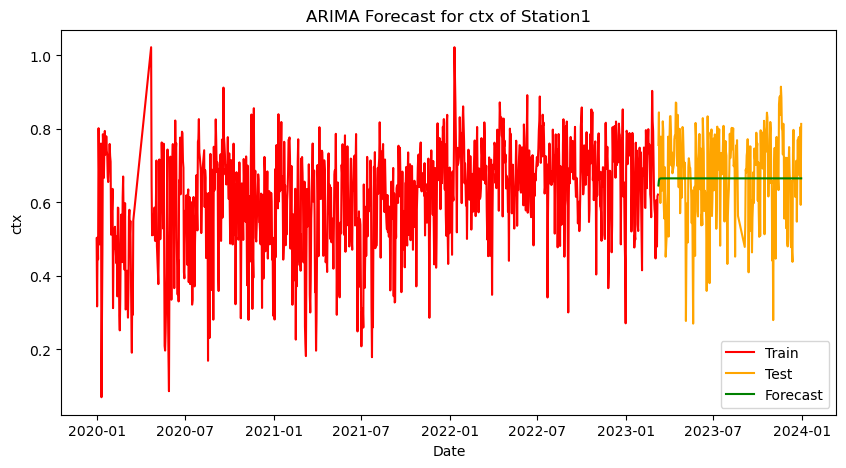

In [24]:
predict_station(1)

Example: Predict ```station_id = 2```

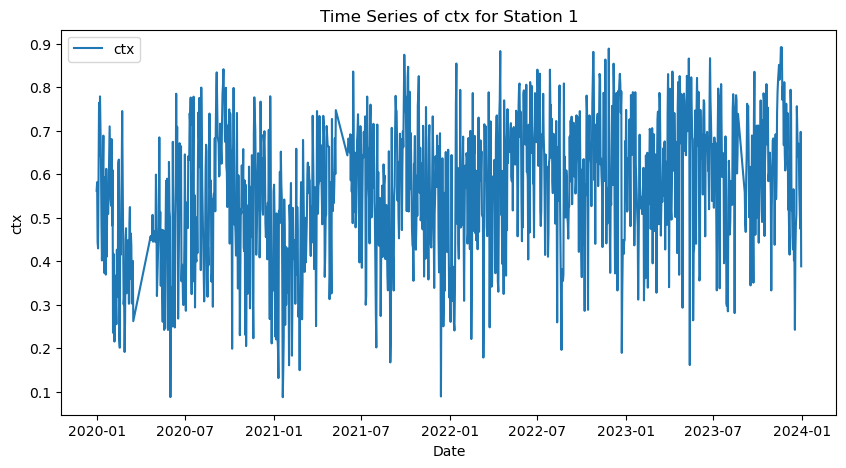

C:\Users\Pol\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Pol\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


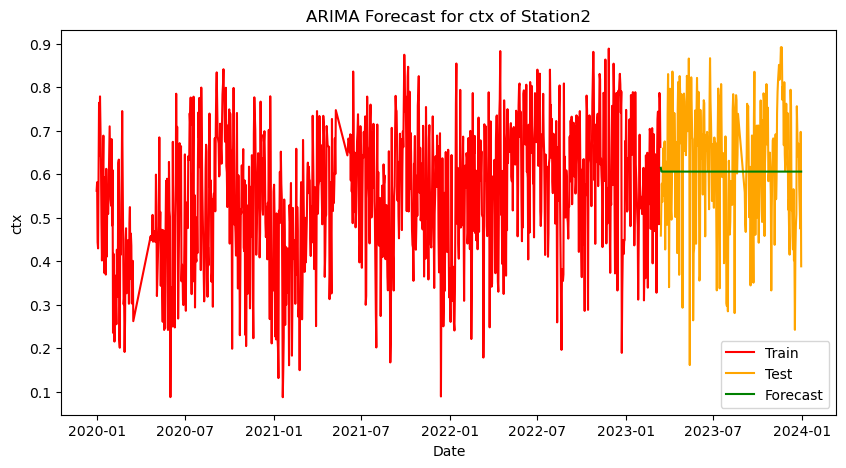

In [25]:
predict_station(2)